In [1]:
import numpy as np
import matplotlib.pyplot as plt
from problem_1.fem import *
from problem_2.OCP import *

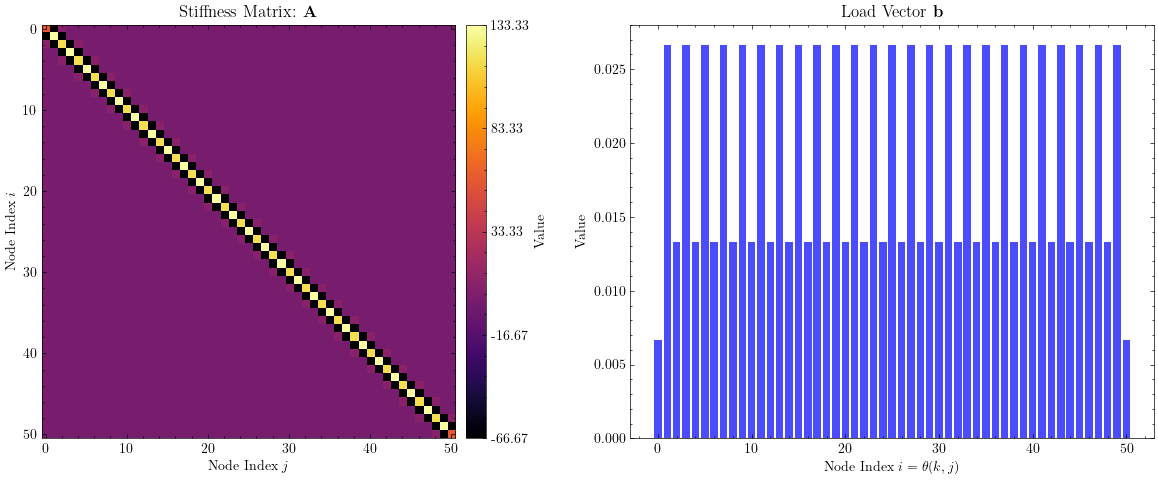


                                             CONVERGENCE ANALYSIS                                             
M        | h            | L² Error        | Rate     | L∞ Error        | Rate     | H¹ Error        | Rate    
---------+--------------+-----------------+----------+-----------------+----------+-----------------+---------
10       | 1.00e-01     | 3.19e-16        | --       | 5.00e-16        | --       | 1.01e-14        | --      
20       | 5.00e-02     | 1.21e-15        | -1.92    | 1.75e-15        | -1.81    | 2.14e-14        | -1.09   
40       | 2.50e-02     | 5.50e-15        | -2.18    | 8.08e-15        | -2.21    | 4.92e-14        | -1.20   
80       | 1.25e-02     | 2.61e-14        | -2.24    | 3.73e-14        | -2.21    | 1.23e-13        | -1.32   
160      | 6.25e-03     | 1.01e-13        | -1.95    | 1.43e-13        | -1.94    | 3.78e-13        | -1.62   
320      | 3.13e-03     | 1.13e-13        | -0.17    | 2.01e-13        | -0.49    | 7.17e-13        | -0.92   


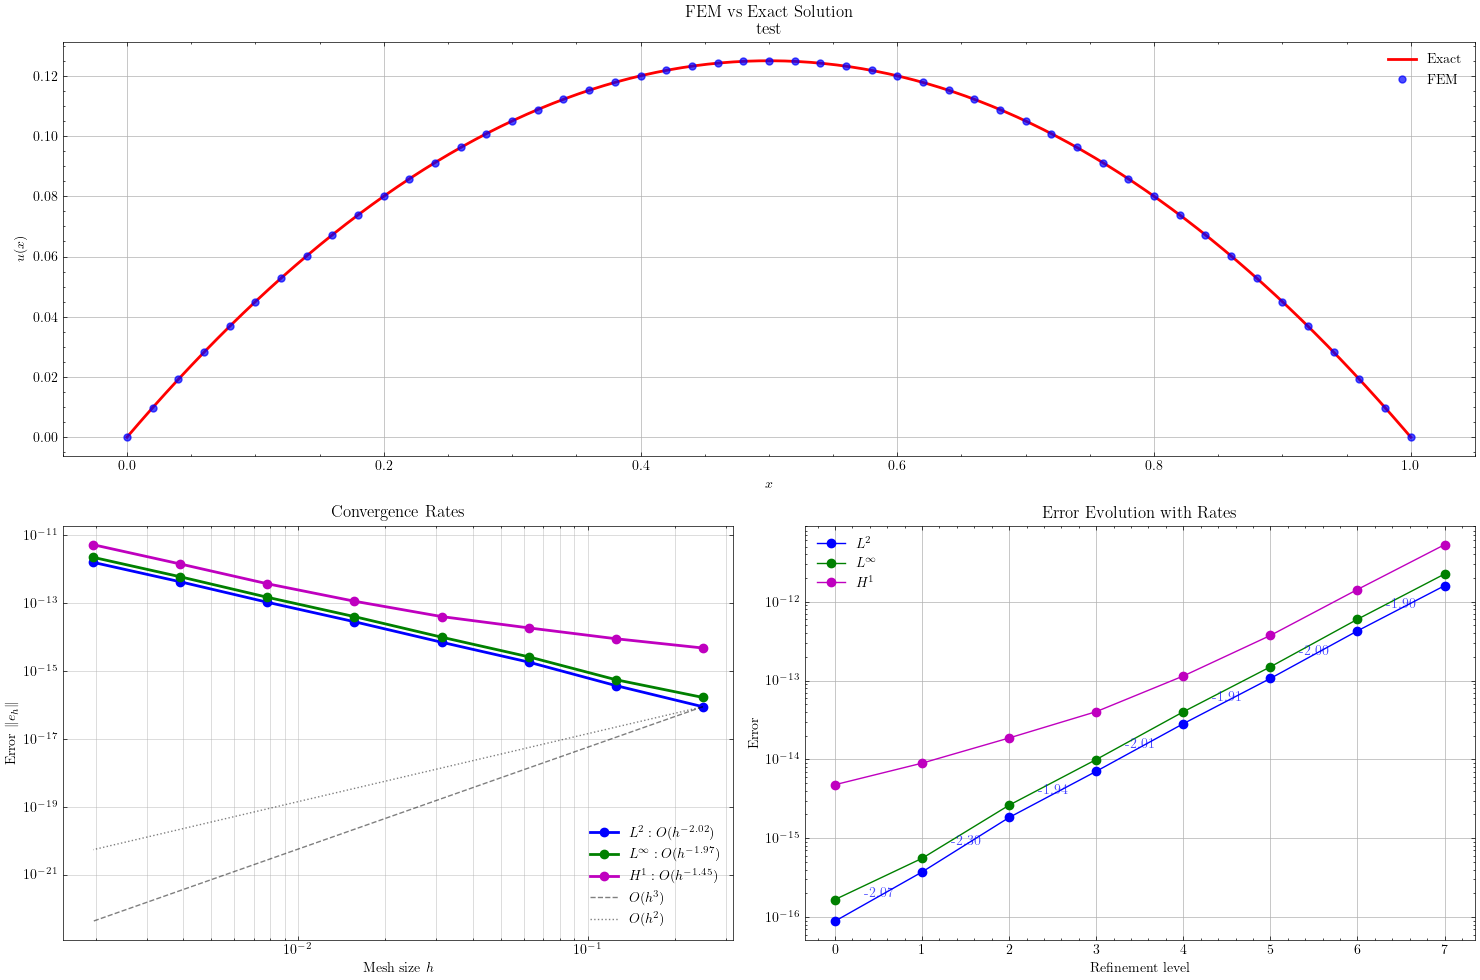

In [ ]:
f1 = lambda x: 1.0
exact1 = lambda x: x*(1-x)/2
du_exact1 = lambda x: 0.5 - x
ddu_exact1 = lambda x: -1.0

smooth = Poisson(
    M=25,
    f=f1,
    u_exact=exact1,
    d_exact=du_exact1,
    dd_exact=ddu_exact1,
)
smooth.solve()
x, uh = smooth.get_solution()
u = smooth.get_exact_solution(x)
# plt.savefig("figures/fem_vs_exact.png", dpi=100)
plot_stiffness_matrix_and_load_vector(smooth, name="simple", savefig=True)
print_convergence_table(smooth, M_list=np.array([10, 20, 40, 80, 160, 320]))
plot_convergence(smooth, name="simple", savefig=True)


In [3]:
f2 = lambda x: np.pi**2 * np.sin(np.pi*x)
exact2 = lambda x: np.sin(np.pi*x)
du_exact2 = lambda x: np.pi * np.cos(np.pi*x)
ddu_exact2 = lambda x: -np.pi**2 * np.sin(np.pi*x)


                                             CONVERGENCE ANALYSIS                                             
M        | h            | L² Error        | Rate     | L∞ Error        | Rate     | H¹ Error        | Rate    
---------+--------------+-----------------+----------+-----------------+----------+-----------------+---------
4        | 2.50e-01     | 1.61e-04        | --       | 3.23e-04        | --       | 4.15e-03        | --      
8        | 1.25e-01     | 2.01e-05        | 3.00     | 4.15e-05        | 2.96     | 1.04e-03        | 2.00    
16       | 6.25e-02     | 2.51e-06        | 3.00     | 5.25e-06        | 2.98     | 2.60e-04        | 2.00    
32       | 3.12e-02     | 3.14e-07        | 3.00     | 6.61e-07        | 2.99     | 6.50e-05        | 2.00    
64       | 1.56e-02     | 3.92e-08        | 3.00     | 8.29e-08        | 3.00     | 1.62e-05        | 2.00    
128      | 7.81e-03     | 4.90e-09        | 3.00     | 1.04e-08        | 3.00     | 4.06e-06        | 2.00    


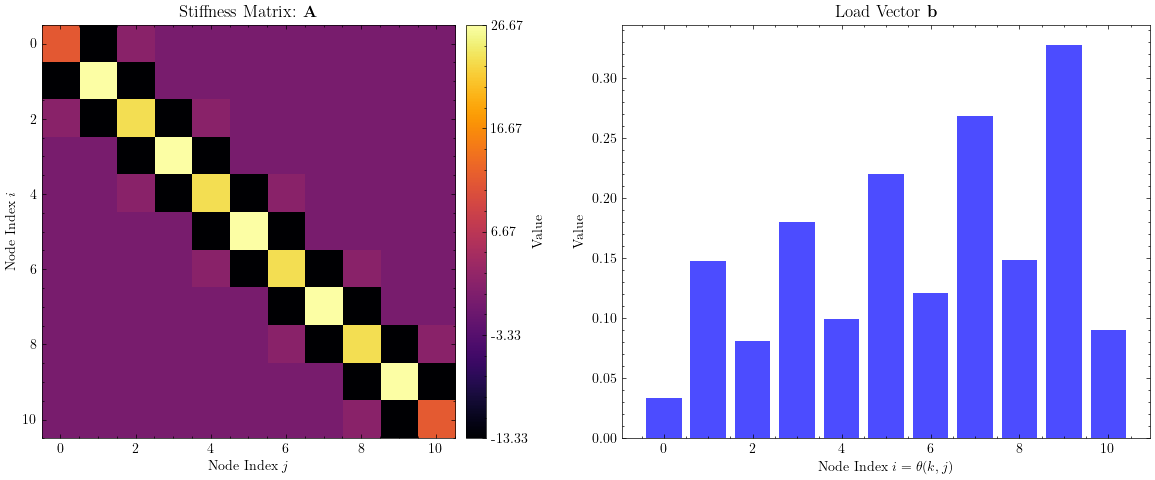


                                             CONVERGENCE ANALYSIS                                             
M        | h            | L² Error        | Rate     | L∞ Error        | Rate     | H¹ Error        | Rate    
---------+--------------+-----------------+----------+-----------------+----------+-----------------+---------
10       | 1.00e-01     | 1.03e-05        | --       | 2.13e-05        | --       | 6.65e-04        | --      
20       | 5.00e-02     | 1.28e-06        | 3.00     | 2.70e-06        | 2.98     | 1.66e-04        | 2.00    
40       | 2.50e-02     | 1.61e-07        | 3.00     | 3.39e-07        | 2.99     | 4.16e-05        | 2.00    
80       | 1.25e-02     | 2.01e-08        | 3.00     | 4.25e-08        | 3.00     | 1.04e-05        | 2.00    
160      | 6.25e-03     | 2.51e-09        | 3.00     | 5.31e-09        | 3.00     | 2.60e-06        | 2.00    
320      | 3.13e-03     | 3.14e-10        | 3.00     | 6.65e-10        | 3.00     | 6.50e-07        | 2.00    


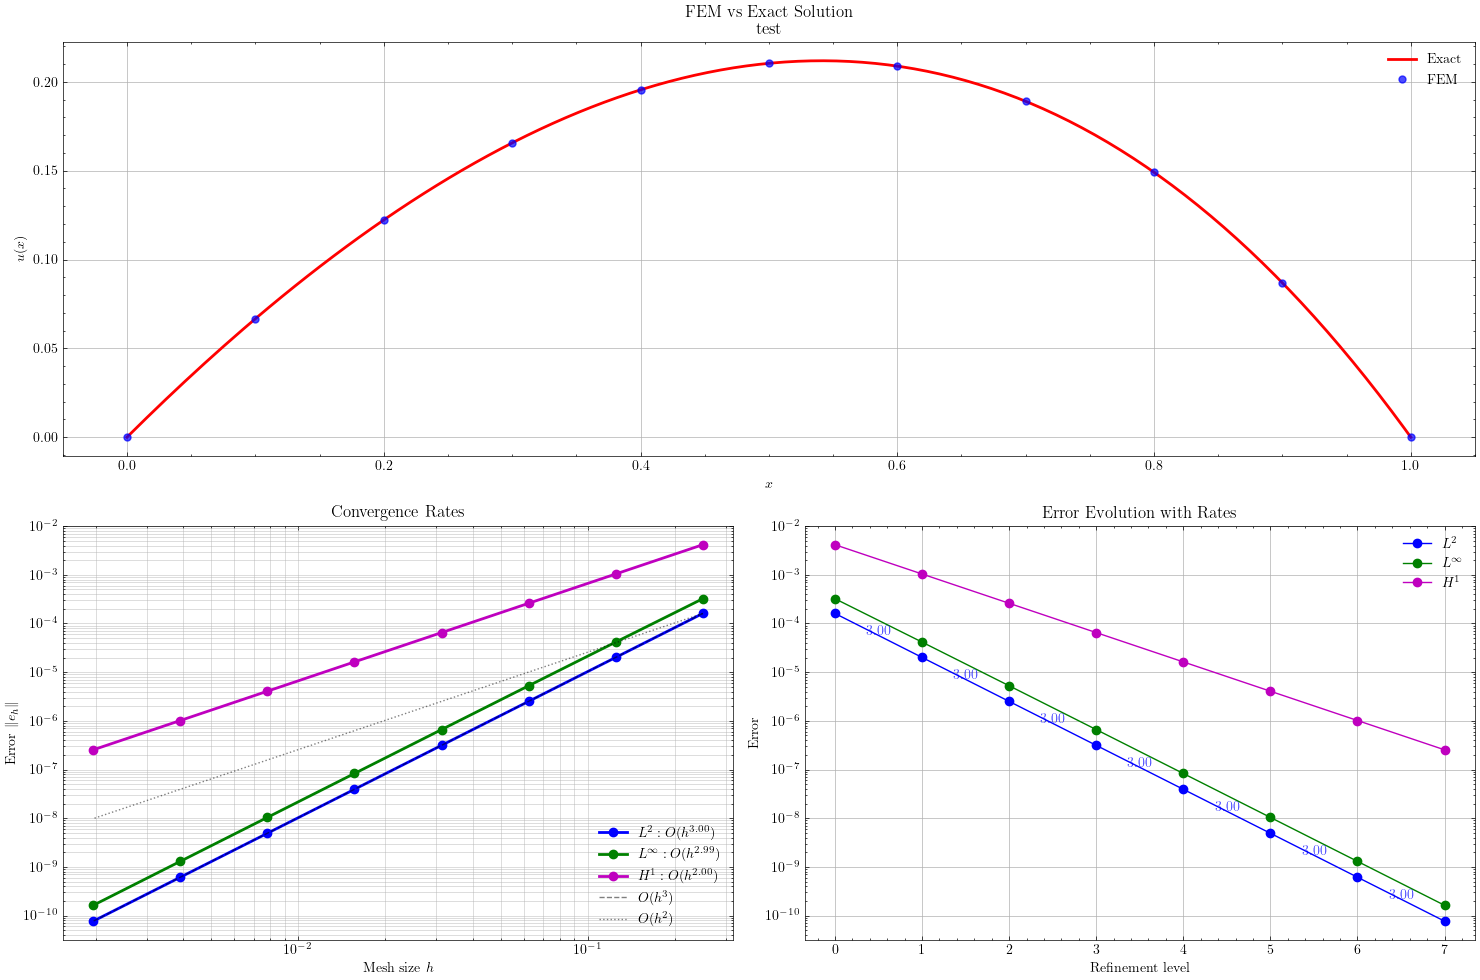

In [11]:
def f_test3(x): return np.exp(x)
def u_exact_test3(x): return -np.exp(x) + (np.e - 1)*x + 1
def du_exact_test3(x): return -np.exp(x) + (np.e - 1)
def ddu_exact_test3(x): return -np.exp(x)
savefig3 = False
solver3 = Poisson(M=5, f=f_test3, u_exact=u_exact_test3, d_exact=du_exact_test3, dd_exact=ddu_exact_test3)
solver3.global_assembly()
solver3.solve()
print_convergence_table(solver3)
plot_stiffness_matrix_and_load_vector(solver3, name="ex3", savefig=savefig3)
print_convergence_table(solver3, M_list=np.array([10, 20, 40, 80, 160, 320]))
plot_convergence(solver3, name="ex3", savefig=savefig3)


                                             CONVERGENCE ANALYSIS                                             
M        | h            | L² Error        | Rate     | L∞ Error        | Rate     | H¹ Error        | Rate    
---------+--------------+-----------------+----------+-----------------+----------+-----------------+---------
4        | 2.50e-01     | 4.98e-04        | --       | 1.13e-03        | --       | 1.17e-02        | --      
8        | 1.25e-01     | 5.73e-05        | 3.12     | 1.46e-04        | 2.95     | 2.90e-03        | 2.01    
16       | 6.25e-02     | 7.02e-06        | 3.03     | 1.84e-05        | 2.99     | 7.23e-04        | 2.00    
32       | 3.12e-02     | 8.73e-07        | 3.01     | 2.30e-06        | 3.00     | 1.81e-04        | 2.00    
64       | 1.56e-02     | 1.09e-07        | 3.00     | 2.88e-07        | 3.00     | 4.52e-05        | 2.00    
128      | 7.81e-03     | 1.36e-08        | 3.00     | 3.60e-08        | 3.00     | 1.13e-05        | 2.00    


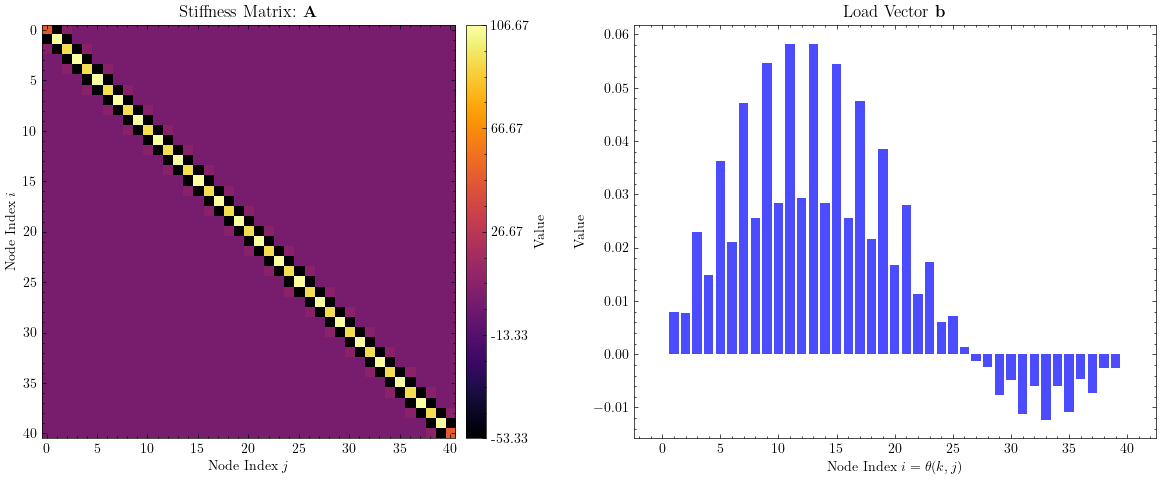

In [ ]:

def u_exact_test4(x):
    return (1.0 / (np.pi**2)) * np.sin(np.pi * x) + (1.0 / (4 * np.pi**2)) * np.sin(2 * np.pi * x)
def du_exact_test4(x):
    return (1.0 / (np.pi**2)) * np.cos(np.pi * x) + (1.0 / (2 * np.pi**2)) * np.cos(2 * np.pi * x)
def ddu_exact_test4(x):
    return -(1.0 / (np.pi**2)) * np.sin(np.pi * x) - (1.0 / (4 * np.pi**2)) * np.sin(2 * np.pi * x)

def f_test4(x):
    return np.sin(np.pi * x) + np.sin(2 * np.pi * x)

savefig4 = False
solver4 = Poisson(M=20, f=f_test4, u_exact=u_exact_test4, d_exact=du_exact_test4, dd_exact=ddu_exact_test4)
solver4.global_assembly()
solver4.solve()

print_convergence_table(solver4)
plot_stiffness_matrix_and_load_vector(solver4, name="ex4", savefig=savefig4)



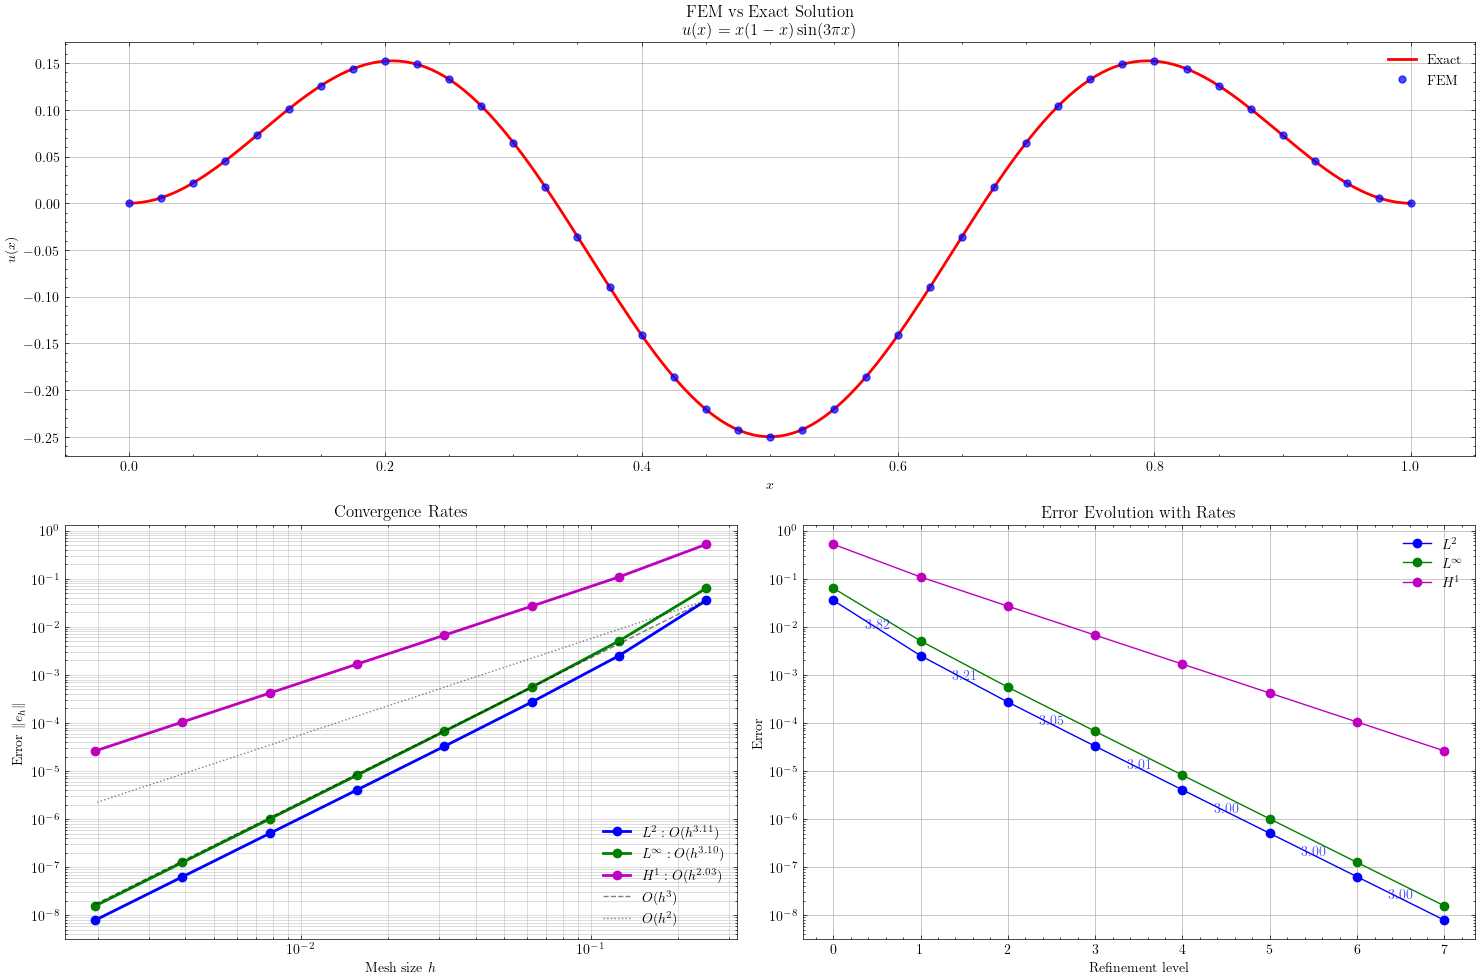

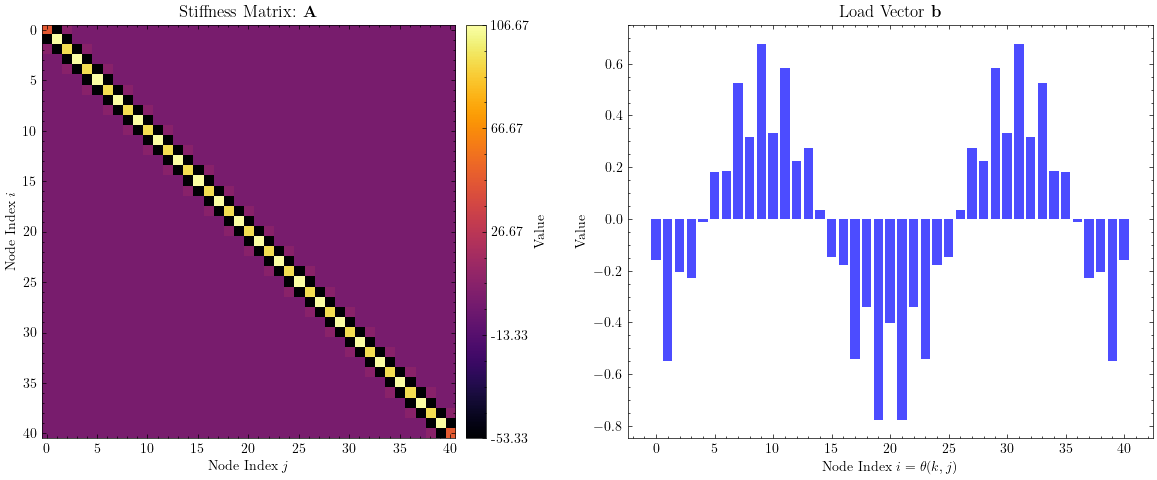


                                             CONVERGENCE ANALYSIS                                             
M        | h            | L² Error        | Rate     | L∞ Error        | Rate     | H¹ Error        | Rate    
---------+--------------+-----------------+----------+-----------------+----------+-----------------+---------
10       | 1.00e-01     | 1.20e-03        | --       | 2.42e-03        | --       | 6.91e-02        | --      
20       | 5.00e-02     | 1.37e-04        | 3.13     | 2.86e-04        | 3.08     | 1.72e-02        | 2.01    
40       | 2.50e-02     | 1.67e-05        | 3.03     | 3.40e-05        | 3.07     | 4.28e-03        | 2.00    
80       | 1.25e-02     | 2.07e-06        | 3.01     | 4.17e-06        | 3.03     | 1.07e-03        | 2.00    
160      | 6.25e-03     | 2.59e-07        | 3.00     | 5.16e-07        | 3.02     | 2.68e-04        | 2.00    
320      | 3.13e-03     | 3.23e-08        | 3.00     | 6.41e-08        | 3.01     | 6.69e-05        | 2.00    


In [15]:
import numpy as np
import sympy as sp

# Define the symbol
x = sp.symbols('x')

# ----------------------
# Test Function 1
# ----------------------
u1_sym = x*(1 - x) * sp.sin(3 * sp.pi * x)
du1_sym = sp.diff(u1_sym, x)
ddu1_sym = sp.diff(du1_sym, x)
f1_sym = -ddu1_sym  # since -u'' = f

# Lambdify these expressions to use with numpy
u1   = sp.lambdify(x, u1_sym, 'numpy')
du1  = sp.lambdify(x, du1_sym, 'numpy')
ddu1 = sp.lambdify(x, ddu1_sym, 'numpy')
f1   = sp.lambdify(x, f1_sym, 'numpy')
label1 = r"$u(x) = x(1-x)\sin(3\pi x)$"
xx = np.linspace(0, 1, 200)

smooth = Poisson(
    M=20,
    f=f1,
    u_exact=u1,
    d_exact=du1,
    dd_exact=ddu1,
)
smooth.solve()
x, uh = smooth.get_solution()
plot_convergence(smooth, name="smooth",label=label1, savefig=True)
plot_stiffness_matrix_and_load_vector(smooth, name="smooth", savefig=True)
print_convergence_table(smooth, M_list=np.array([10, 20, 40, 80, 160, 320, 640, 1280, 2560]))

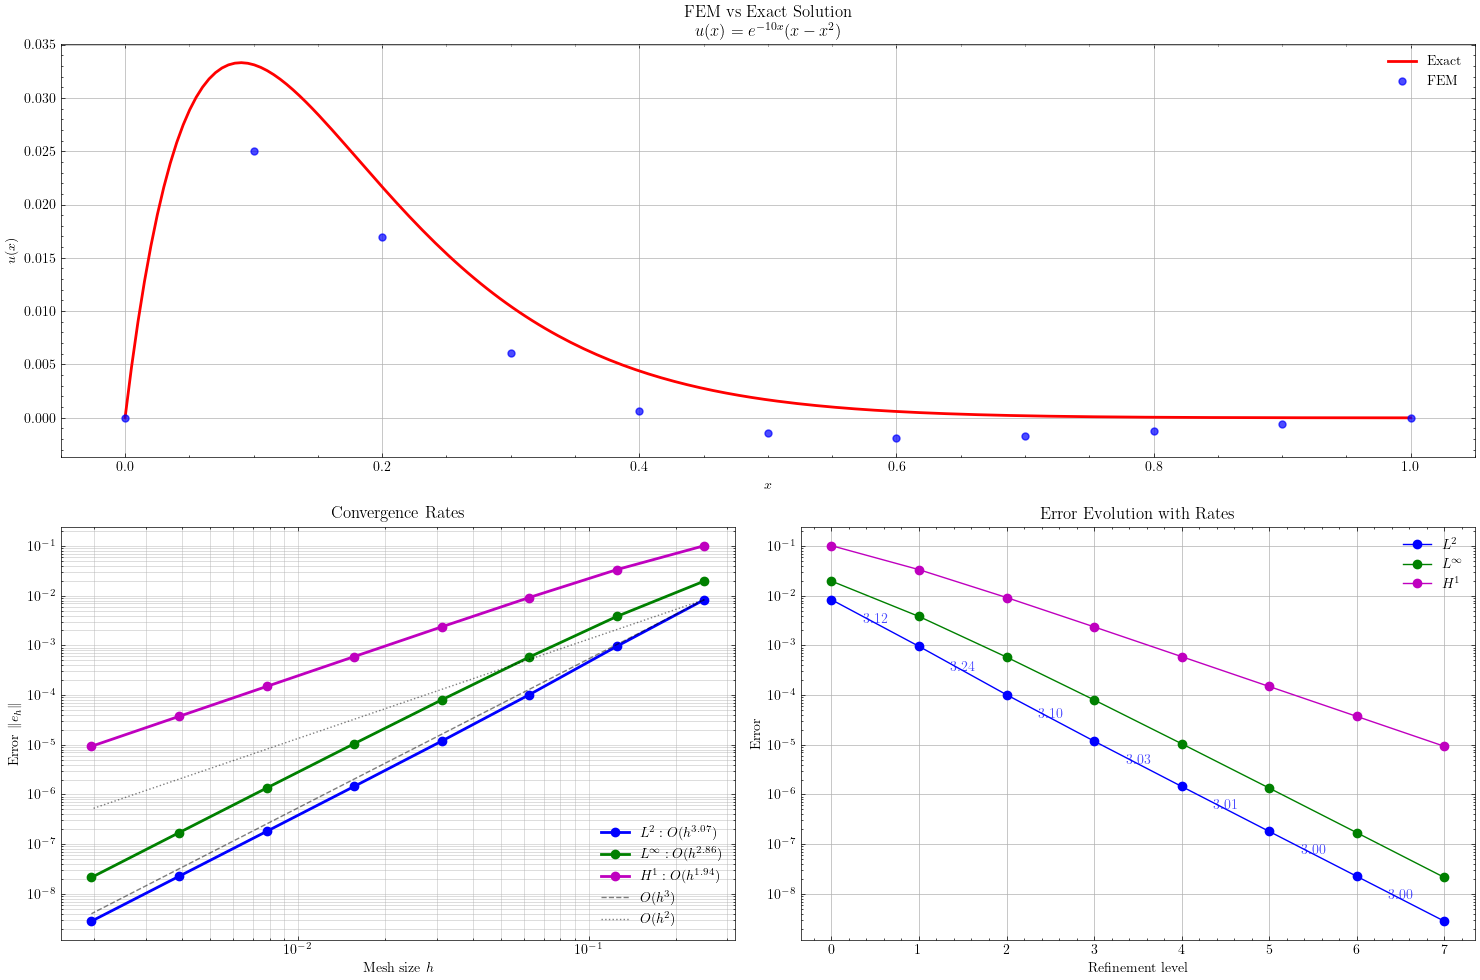

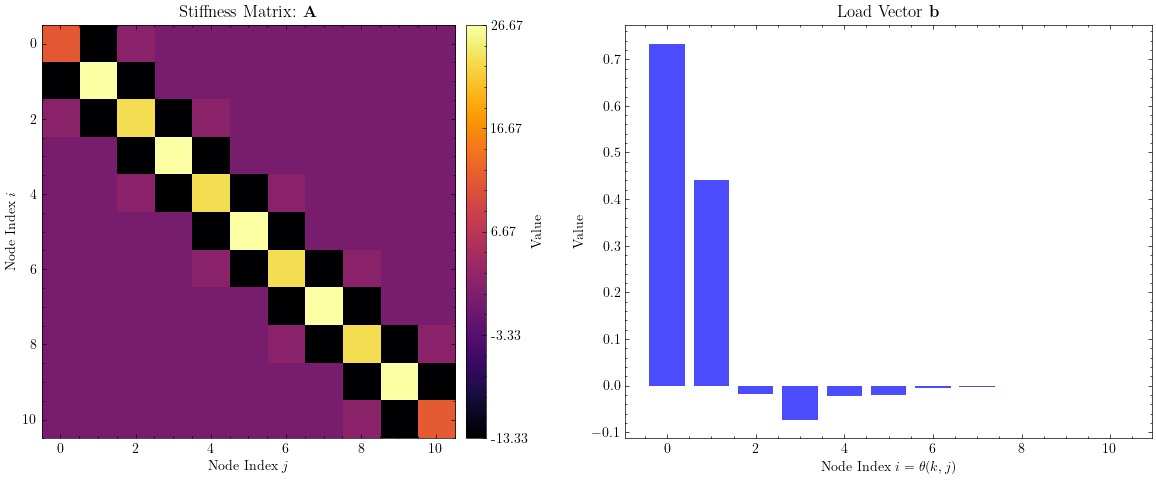

In [31]:
x = sp.symbols('x')

u2_sym = sp.exp(-10 * x) * (x - x**2)
du2_sym = sp.diff(u2_sym, x)
ddu2_sym = sp.diff(du2_sym, x)
f2_sym = -ddu2_sym

u2   = sp.lambdify(x, u2_sym, 'numpy')
du2  = sp.lambdify(x, du2_sym, 'numpy')
ddu2 = sp.lambdify(x, ddu2_sym, 'numpy')
f2   = sp.lambdify(x, f2_sym, 'numpy')

label2 = r"$u(x) = e^{-10x}(x-x^2)$"

ex2 = Poisson(
    M=5,
    f=f2,
    u_exact=u2,
    d_exact=du2,
    dd_exact=ddu2,
)
ex2.solve()
x, uh = ex2.get_solution()
plot_convergence(ex2, name="smooth_damped",label=label2, savefig=True)
plot_stiffness_matrix_and_load_vector(ex2, name="smooth_damped", savefig=True)

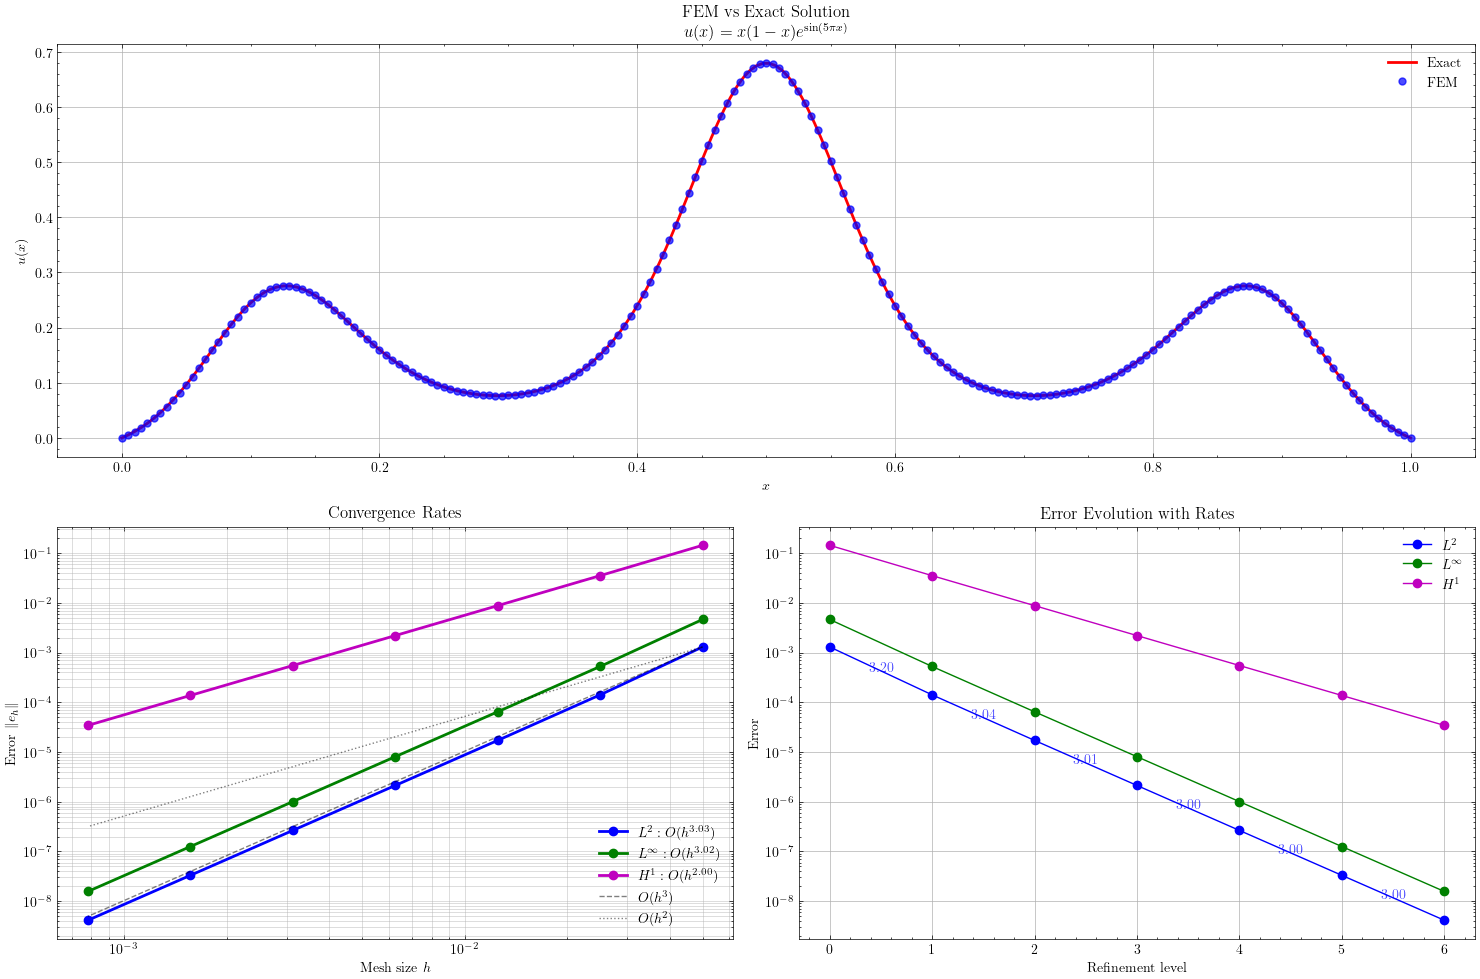


                                             CONVERGENCE ANALYSIS                                             
M        | h            | L² Error        | Rate     | L∞ Error        | Rate     | H¹ Error        | Rate    
---------+--------------+-----------------+----------+-----------------+----------+-----------------+---------
10       | 1.00e-01     | 1.19e-01        | --       | 2.38e-01        | --       | 8.06e-01        | --      
20       | 5.00e-02     | 1.30e-03        | 6.51     | 4.63e-03        | 5.69     | 1.43e-01        | 2.49    
40       | 2.50e-02     | 1.41e-04        | 3.20     | 5.25e-04        | 3.14     | 3.52e-02        | 2.03    
80       | 1.25e-02     | 1.71e-05        | 3.04     | 6.44e-05        | 3.03     | 8.79e-03        | 2.00    
160      | 6.25e-03     | 2.12e-06        | 3.01     | 8.05e-06        | 3.00     | 2.20e-03        | 2.00    
320      | 3.13e-03     | 2.65e-07        | 3.00     | 1.01e-06        | 3.00     | 5.49e-04        | 2.00    


In [21]:
# ----------------------
# Test Function 3
# ----------------------
x = sp.symbols('x')
u3_sym = x*(1 - x) * sp.exp(sp.sin(5 * sp.pi * x))
du3_sym = sp.diff(u3_sym, x)
ddu3_sym = sp.diff(du3_sym, x)
f3_sym = -ddu3_sym

u3   = sp.lambdify(x, u3_sym, 'numpy')
du3  = sp.lambdify(x, du3_sym, 'numpy')
ddu3 = sp.lambdify(x, ddu3_sym, 'numpy')
f3   = sp.lambdify(x, f3_sym, 'numpy')
label3 = r"$u(x) = x(1-x)e^{\sin(5\pi x)}$"

complex = Poisson(
    M=100,
    f=f3,
    u_exact=u3,
    d_exact=du3,
    dd_exact=ddu3,
    N_fine=100
)
complex.solve()
x, uh = complex.get_solution()
plot_convergence(complex, name="complex",label=label3, savefig=True, M_list=np.array([20, 40, 80, 160, 320, 640, 1280]))
print_convergence_table(complex, M_list=np.array([10, 20, 40, 80, 160, 320, 640, 1280]))

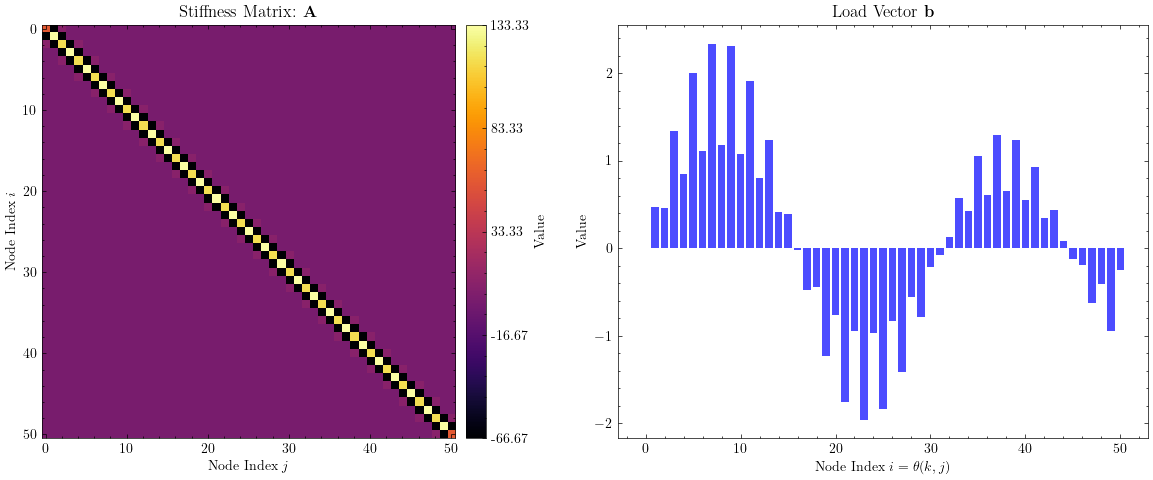


                                             CONVERGENCE ANALYSIS                                             
M        | h            | L² Error        | Rate     | L∞ Error        | Rate     | H¹ Error        | Rate    
---------+--------------+-----------------+----------+-----------------+----------+-----------------+---------
10       | 1.00e-01     | 3.18e-03        | --       | 6.98e-03        | --       | 1.94e-01        | --      
20       | 5.00e-02     | 3.79e-04        | 3.07     | 8.90e-04        | 2.97     | 4.83e-02        | 2.00    
40       | 2.50e-02     | 4.67e-05        | 3.02     | 1.12e-04        | 2.99     | 1.21e-02        | 2.00    
80       | 1.25e-02     | 5.82e-06        | 3.00     | 1.40e-05        | 3.00     | 3.01e-03        | 2.00    
160      | 6.25e-03     | 7.27e-07        | 3.00     | 1.75e-06        | 3.00     | 7.53e-04        | 2.00    
320      | 3.13e-03     | 9.09e-08        | 3.00     | 2.19e-07        | 3.00     | 1.88e-04        | 2.00    


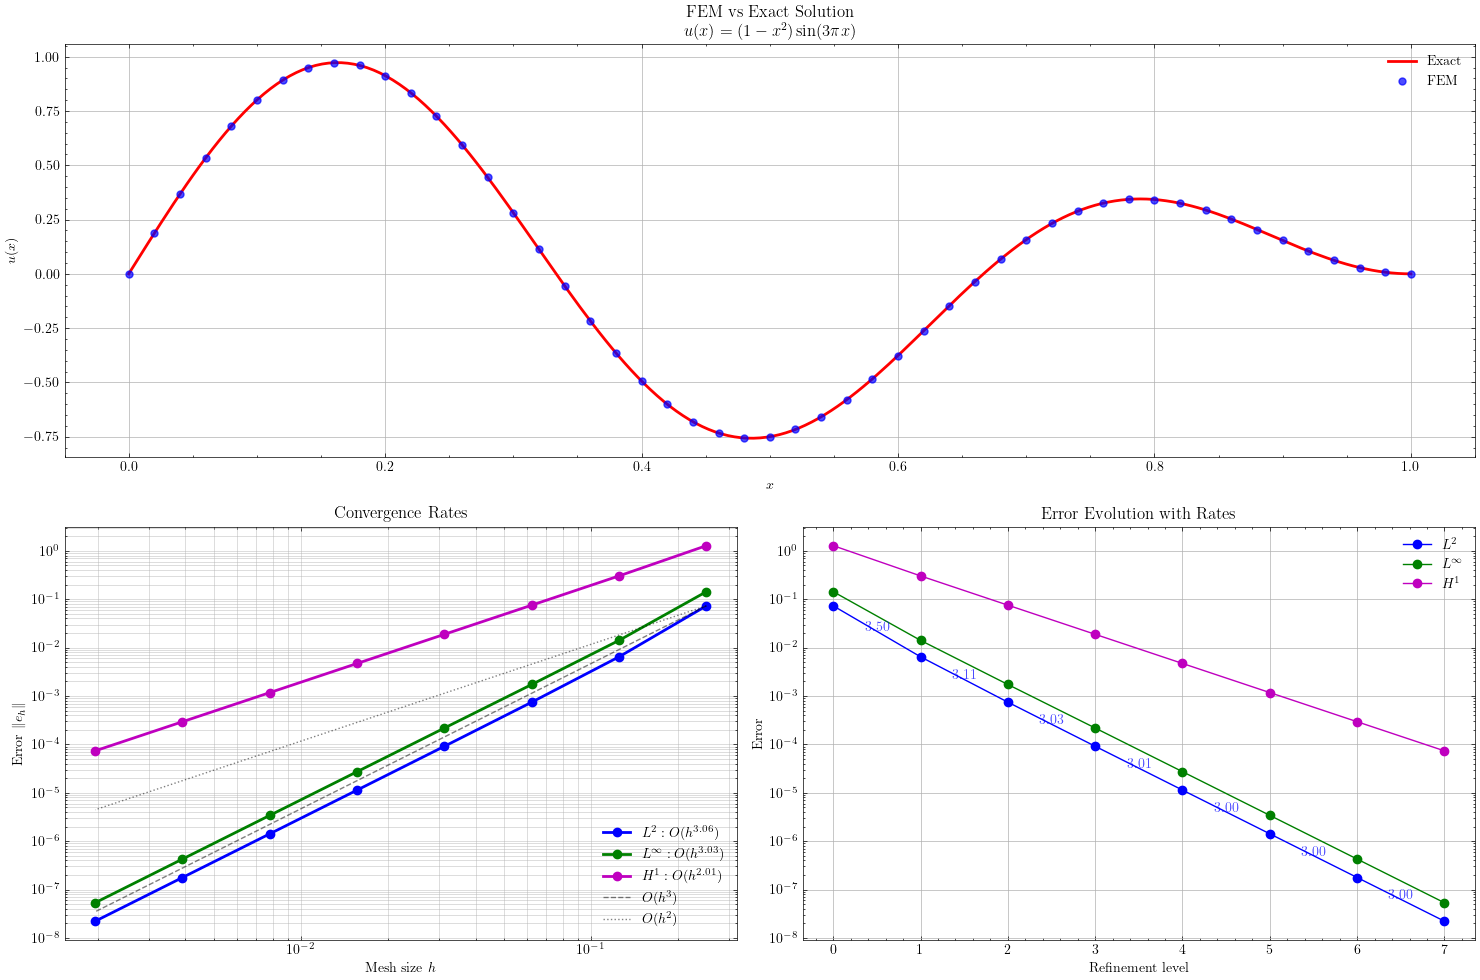

In [27]:
# ----------------------
# Test Function 4 (Heart Shape)
# ----------------------
x = sp.symbols('x')
u4_sym = (1 - x**2) * sp.sin(3 * sp.pi * x)
du4_sym = sp.diff(u4_sym, x)
ddu4_sym = sp.diff(du4_sym, x)
f4_sym = -ddu4_sym
u4   = sp.lambdify(x, u4_sym, 'numpy')
du4  = sp.lambdify(x, du4_sym, 'numpy')
ddu4 = sp.lambdify(x, ddu4_sym, 'numpy')
f4   = sp.lambdify(x, f4_sym, 'numpy')
label4 = r"$u(x) = (1-x^2)\sin(3\pi x)$"

ex4 = Poisson(
    M=25,
    f=f4,
    u_exact=u4,
    d_exact=du4,
    dd_exact=ddu4,
)
ex4.solve()
x, uh = ex4.get_solution()
plot_stiffness_matrix_and_load_vector(ex4, name="complex_2", savefig=False)
print_convergence_table(ex4, M_list=np.array([10, 20, 40, 80, 160, 320]))
plot_convergence(ex4, name="complex_2",label=label4, savefig=False)


Convergence Table for yd_case1:
alpha      n          L2 Error        L2 Rate         L2 Order        H1 Error        H1 Rate         H1 Order       
0.01       4          0.006345        nan             nan             0.010392        nan             nan            
0.01       8          0.002499        1.344161        -2.881409       0.011326        -0.124173       -2.154724      
0.01       16         0.001064        1.232689        -2.469229       0.008266        0.454465        -1.729659      
0.01       32         0.000443        1.264415        -2.228266       0.005774        0.517517        -1.487231      
0.01       64         0.000185        1.255462        -2.066132       0.003827        0.593555        -1.338285      
0.01       128        0.000078        1.252804        -1.949942       0.002438        0.650127        -1.239976      
0.0001     4          0.000309        nan             nan             0.003475        nan             nan            
0.0001     8          0.

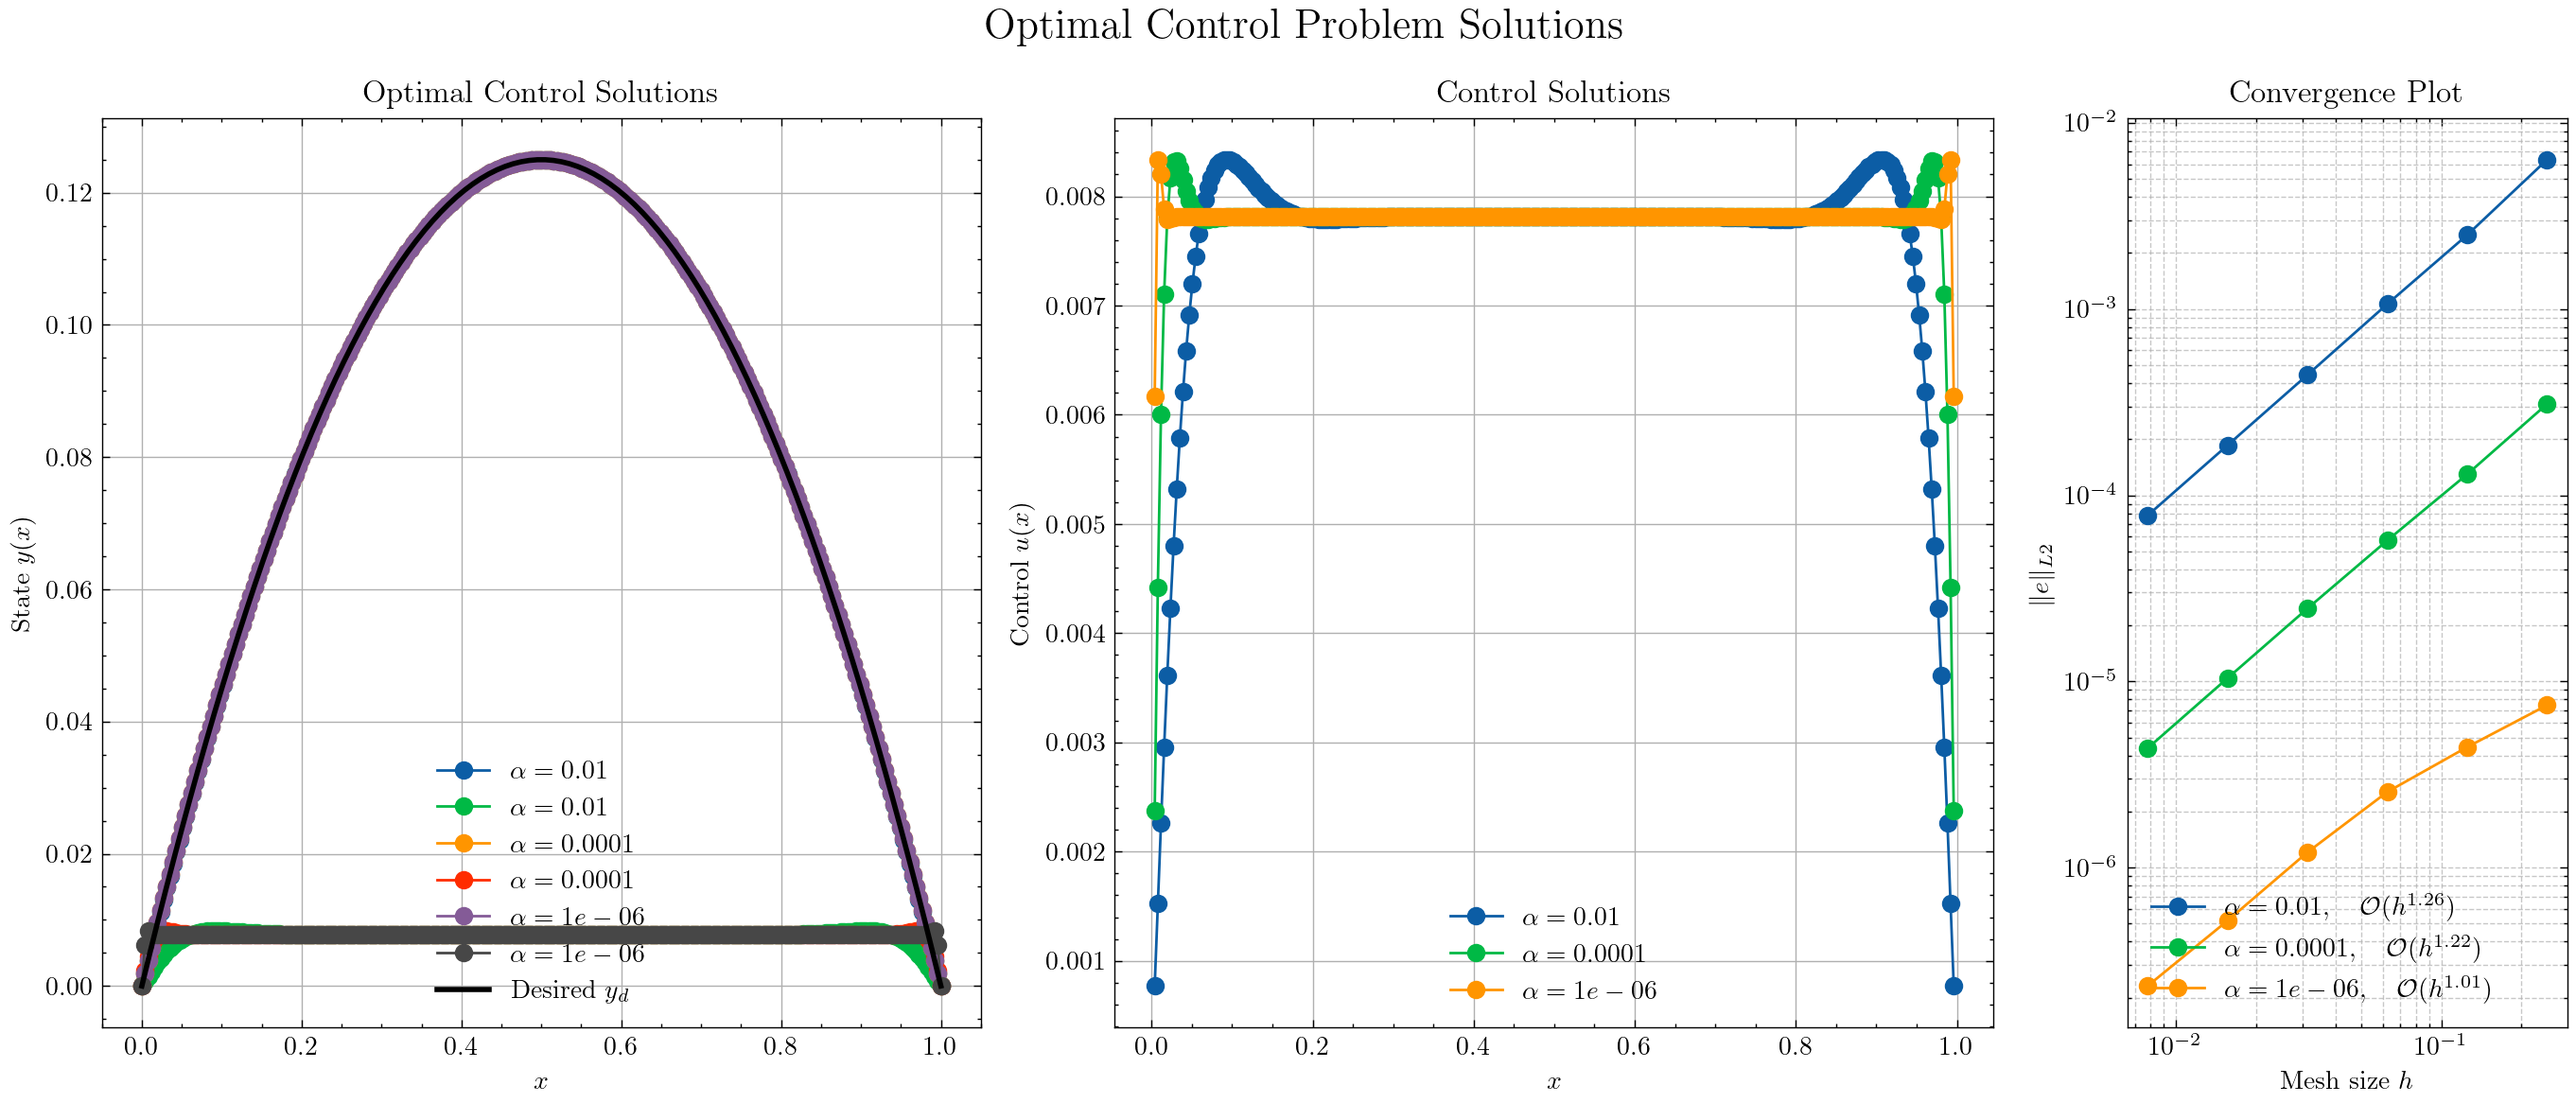



Convergence Table for yd_case2:
alpha      n          L2 Error        L2 Rate         L2 Order        H1 Error        H1 Rate         H1 Order       
0.01       4          0.270352        nan             nan             2.066545        nan             nan            
0.01       8          0.266085        0.022952        -0.636680       2.576473        -0.318176       0.455133       
0.01       16         0.239538        0.151631        -0.515418       3.272583        -0.345032       0.427607       
0.01       32         0.213174        0.168228        -0.445980       4.048530        -0.306968       0.403480       
0.01       64         0.186429        0.193402        -0.403883       4.931085        -0.284507       0.383651       
0.01       128        0.161157        0.210163        -0.376209       5.954926        -0.272178       0.367726       
0.0001     4          0.055638        nan             nan             0.671054        nan             nan            
0.0001     8          

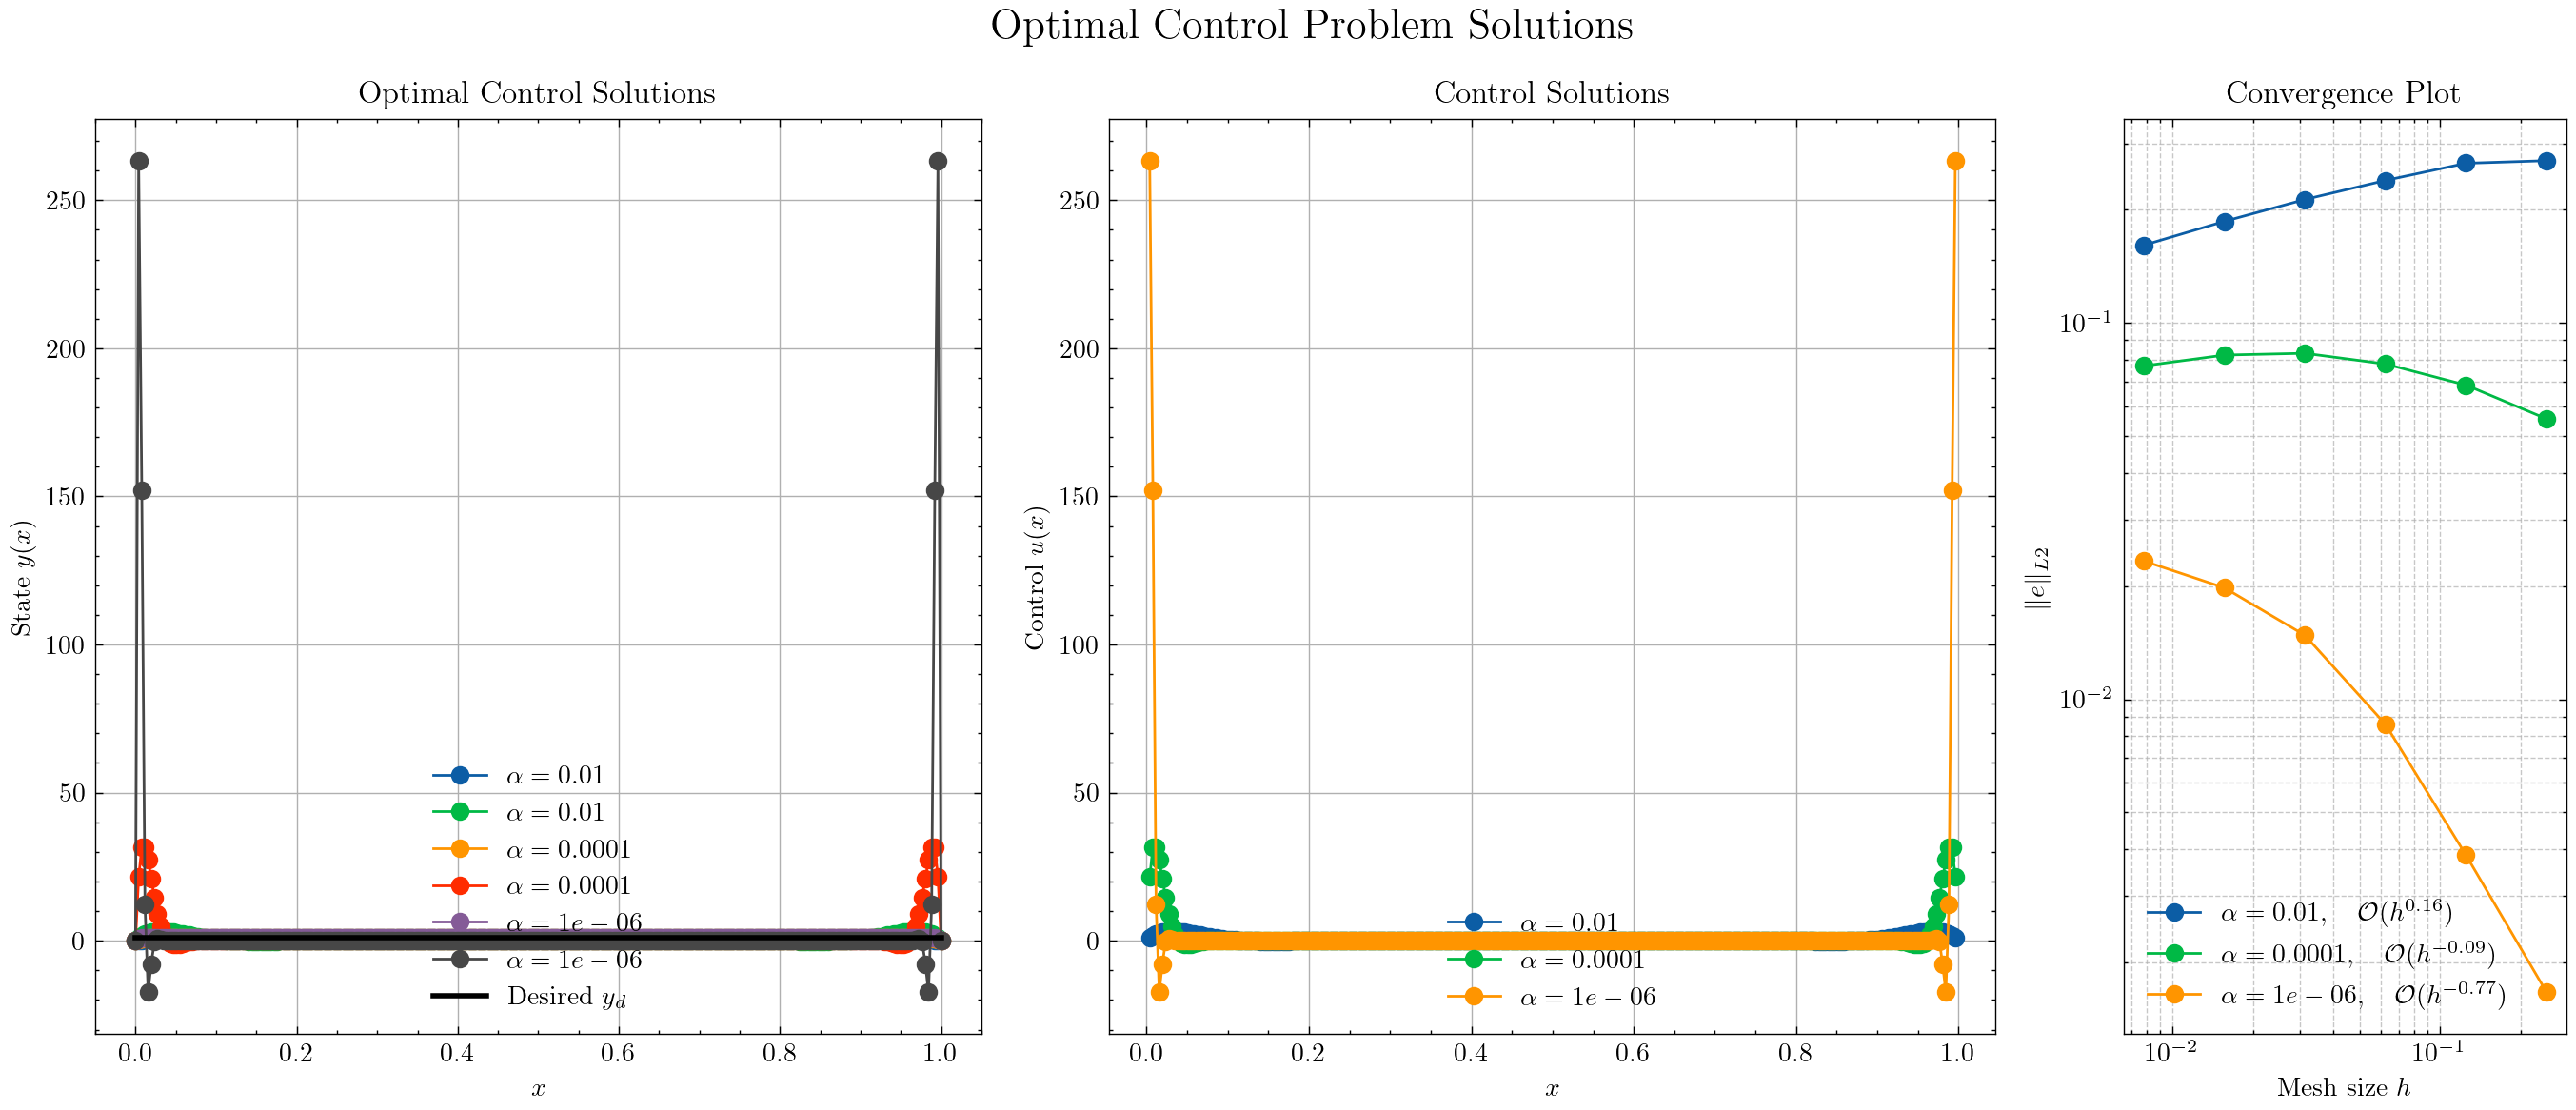



Convergence Table for yd_case3:
alpha      n          L2 Error        L2 Rate         L2 Order        H1 Error        H1 Rate         H1 Order       
0.01       4          0.260253        nan             nan             3.115391        nan             nan            
0.01       8          0.244090        0.092502        -0.678172       3.092364        0.010703        0.542903       
0.01       16         0.207382        0.235117        -0.567409       4.708724        -0.606626       0.558834       
0.01       32         0.172798        0.263207        -0.506568       7.025900        -0.577347       0.562537       
0.01       64         0.145044        0.252600        -0.464240       10.333750       -0.556609       0.561549       
0.01       128        0.121858        0.251290        -0.433819       15.016081       -0.539144       0.558348       
0.0001     4          0.122636        nan             nan             1.387773        nan             nan            
0.0001     8          

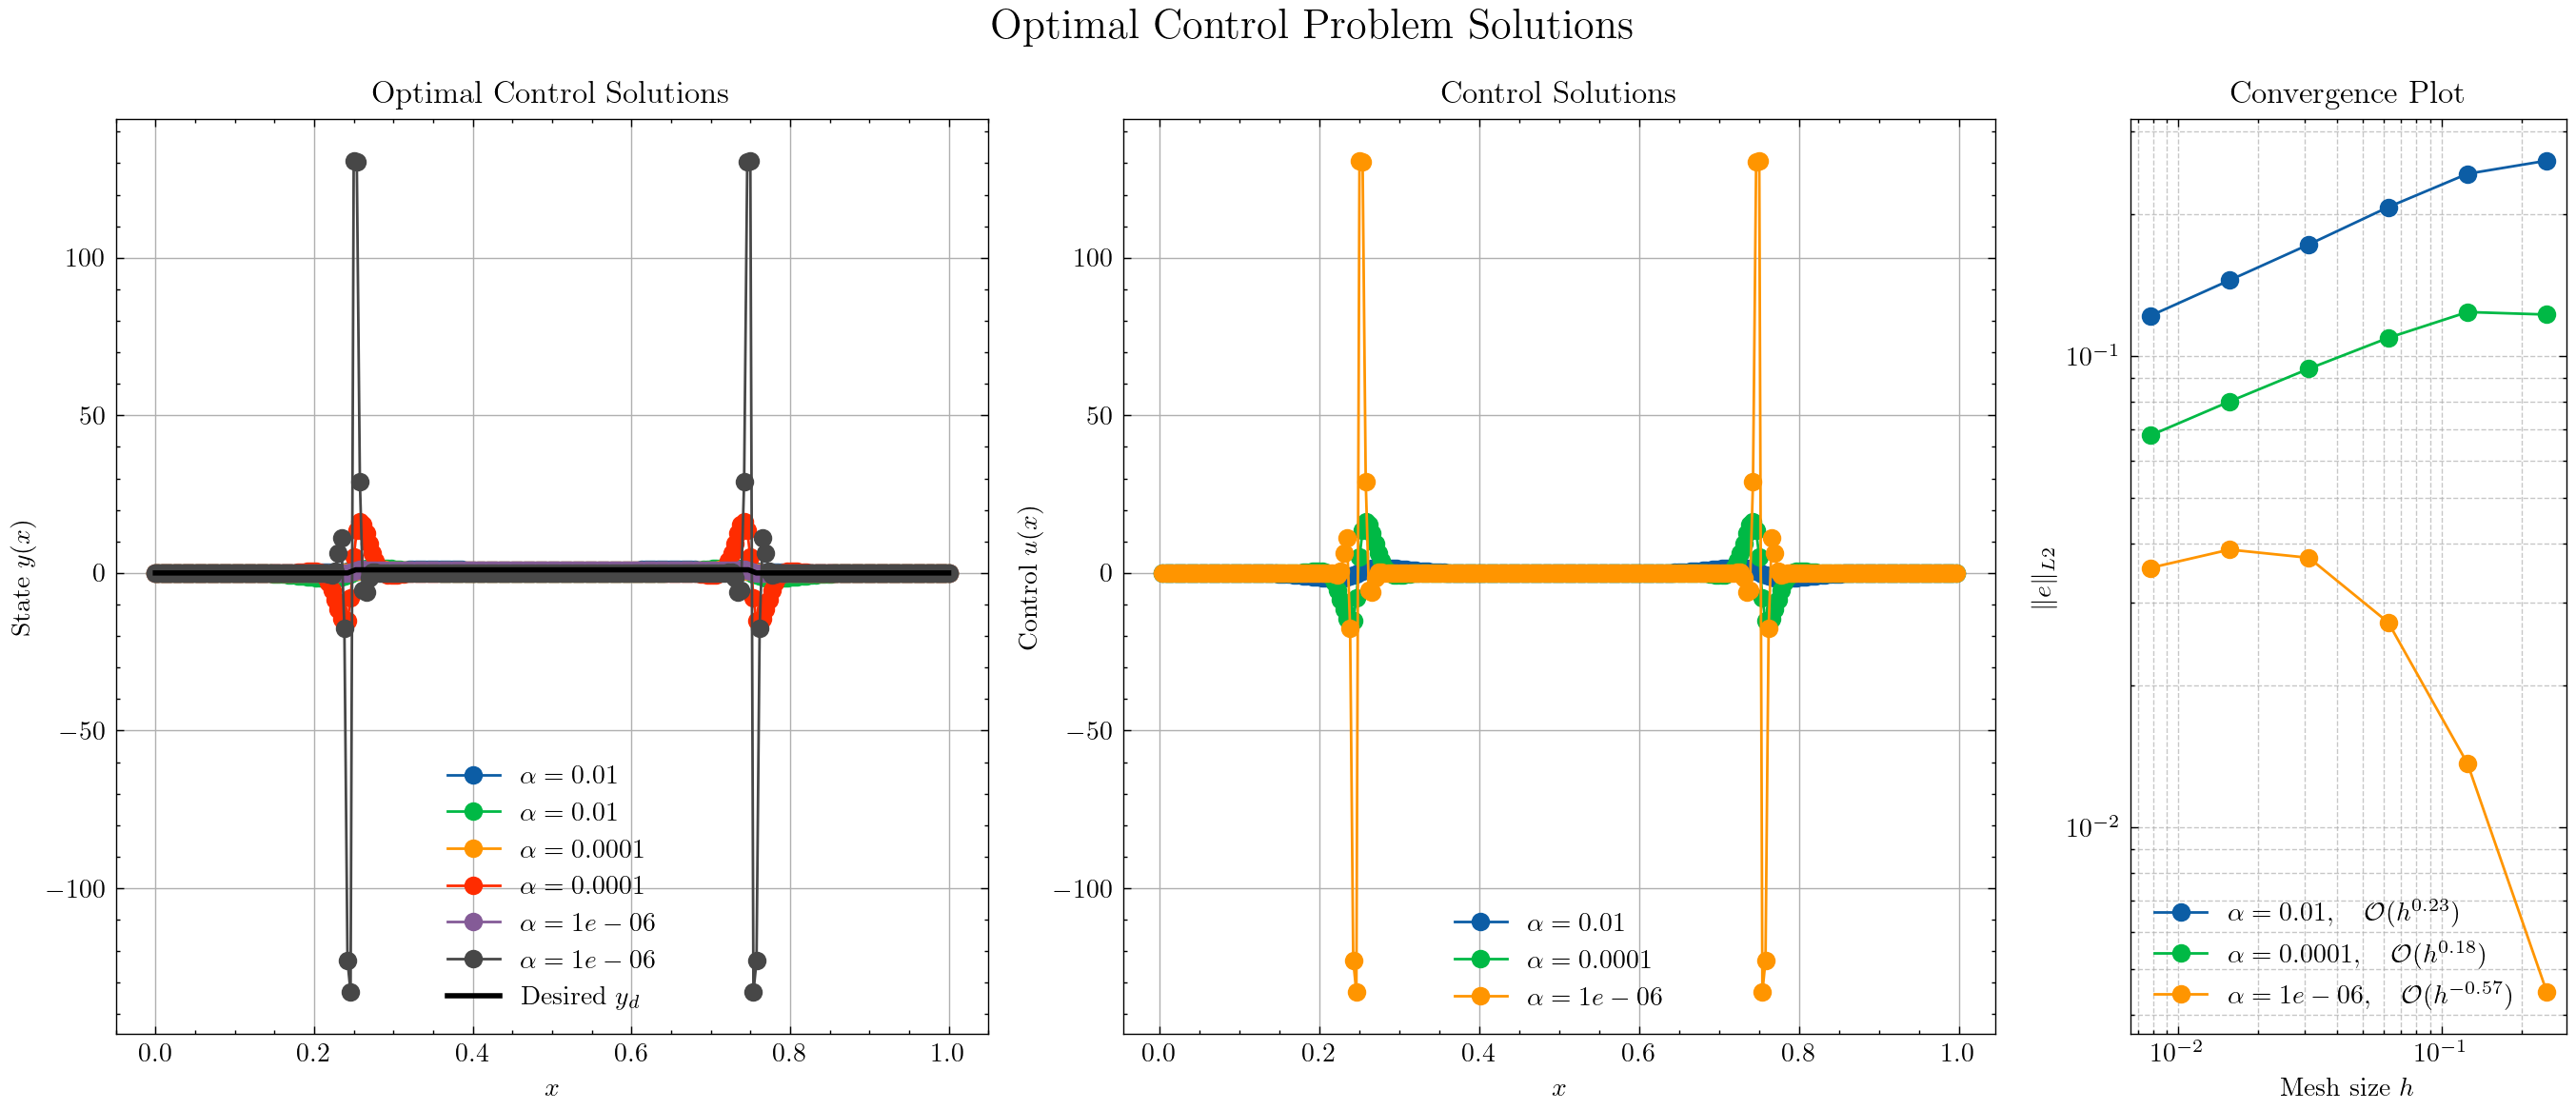

In [10]:
from problem_2.OCP import print_convergence, plot_opt_control_multi

def yd_case1(x): 
    return 0.5 * x * (1 - x)

def yd_case2(x): 
    return np.ones_like(x)

def yd_case3(x): 
    return np.where((x >= 0.25) & (x <= 0.75), 1.0, 0.0)

cases = [(yd_case1, "Case 1"),
         (yd_case2, "Case 2"),
         (yd_case3, "Case 3")]


alphas = [1e-2, 1e-4, 1e-6]
n_elements = 50
solver = FEMSolver(n_elements)
n_vals = [4, 8, 16, 32, 64, 128]

for yd_case, title in cases:
    print_convergence(solver, yd_case, alphas, n_vals)
    plot_opt_control_multi(alphas, n_vals, yd_case, fine_mesh=100, savefig=False, name=title)
    print("\n")

